# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
!pip install -U seaborn
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score 

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)


## Portfolio Data

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
#Creating copy of the file keeping the original intact
portfolio_working = portfolio.copy()

## Cleaning Portfolio Data

1. The channel column needs to be cleaned: each unique value should be encoded in separate columns. 

In [5]:
for i in ["web", "email", "mobile", "social"]:
    portfolio_working[i] = portfolio_working['channels'].apply(lambda x:1 if i in x else 0)
portfolio_working.drop(columns='channels',inplace = True)
portfolio_working.head()

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [6]:
#2. changing the column name of id to offer id
portfolio_working = portfolio_working.rename(columns={'id':'offer_id'})

In [7]:
#3. Expanding the offer type across columns
for i in ["bogo", "discount", "informational"]:
    portfolio_working[i] = portfolio_working['offer_type'].apply(lambda x:1 if x==i else 0)
portfolio_working.drop(columns='offer_type',inplace = True)
portfolio_working.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


## Profile Data

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


## Cleaning Profile Data

In [10]:
#1. changing the name of the id column to customer_id
profile_working = profile.copy().rename(columns={'id':'customer_id'})

In [11]:
#2. Formatting the became member on Column
profile_working['became_member_on'] = pd.to_datetime(profile_working['became_member_on'], format='%Y%m%d')

In [12]:
#creating columns for year and month from date 
profile_working['start_year'] = profile_working['became_member_on'].dt.year
profile_working["start_month"] = profile_working['became_member_on'].dt.month

In [13]:
profile_working.drop(columns='became_member_on',inplace = True)
profile_working.head()

,age,gender,customer_id,income,start_year,start_month
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8


In [14]:
#3. Changing nan values age from 118 to nan
profile_working['age'].replace(118, np.nan, inplace=True)

In [15]:
#4. Dropping null values in demographic data
profile_working = profile_working[profile_working['age'].notnull()].reset_index(drop = True)

In [16]:
profile_working['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [17]:
#5. Expanding gender information across columns
for i in ["M", "F", "O"]:
    profile_working[i] = profile_working['gender'].apply(lambda x:1 if x==i else 0)
profile_working.drop(columns='gender',inplace = True)


In [18]:
profile_working.head()

,age,customer_id,income,start_year,start_month,M,F,O
0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,0,1,0
1,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,0,1,0
2,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,1,0,0
3,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,1,0,0
4,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,1,0,0


## Transcript Data

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
#1. Changing the column name from person to customer id
transcript_working = transcript.copy().rename(columns={'person':'customer_id'})

In [21]:
#2.Expanding events across columns 
unique_events = list(transcript_working['event'].unique())

In [22]:
for i in unique_events:
    transcript_working[i] = transcript_working['event'].apply(lambda x:1 if i == x else 0)



In [23]:
#3. Expanding values across columns
values = transcript_working['value'].apply(lambda x:list(x.keys())[0])

In [24]:
values = set(list(values))
print(values)

{'offer_id', 'offer id', 'amount'}


In [25]:
for i in values:
    transcript_working[i] = transcript_working['value'].apply(lambda x:list(x.values())[0] if list(x.keys())[0] == i else float("NaN"))
transcript_working.drop(columns='value',inplace = True)

In [26]:
#Function to combine offer_id and offer id values in one column
def make_one_column(x):
    if type(x['offer_id']) ==float:
        return x['offer id']
    else:
        return x['offer_id']
        

In [27]:
transcript_working['offer_id'] = transcript_working.apply(make_one_column, axis=1)

In [28]:
transcript_working.drop(columns='offer id',inplace = True)
transcript_working.head()


,event,customer_id,time,offer received,offer viewed,transaction,offer completed,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [29]:
#4. converting time to days
transcript_working['time'] =  transcript_working['time']/24.0

In [30]:
#5. Selecting only values from profile that has demographic data
customer_ids_nonnull = list(profile_working['customer_id'].unique())

In [31]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript_working = transcript_working[transcript_working.customer_id.isin(customer_ids_nonnull)]

In [32]:
transcript_working.head()

,event,customer_id,time,offer received,offer viewed,transaction,offer completed,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [33]:
#6. Selecting only the transaction data from transcript and creating a separate dataset from it
transaction_df = transcript_working[transcript_working['transaction']==1]
transaction_df = transaction_df.drop(columns=['offer_id', 'event'])

In [34]:
#7. Selecting only non-transaction data from transcript and creating a separate dataset from it
non_transaction_df = transcript_working[transcript_working['transaction']!=1]
non_transaction_df = non_transaction_df.drop(columns=['amount', 'event'])

In [35]:
transaction_df = transaction_df.reset_index(drop=True)

non_transaction_df = non_transaction_df.reset_index(drop=True)


In [36]:
transaction_df.head()

,customer_id,time,offer received,offer viewed,transaction,offer completed,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0,0,1,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,0,0,1,0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,0,0,1,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,0,0,1,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,0,0,1,0,18.97


In [37]:
non_transaction_df.head()

,customer_id,time,offer received,offer viewed,transaction,offer completed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,0.0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,0.0,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,1,0,0,0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
#Finding the total number of offers received by customers sent by Starbucks
non_transaction_df['offer received'].sum()

66501

In [39]:
non_transaction_df['offer completed'].sum()

32444

In [40]:
non_transaction_df[['customer_id','offer_id']].head()

,customer_id,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [41]:
##check = non_transaction_df[(non_transaction_df['customer_id'] =='78afa995795e4d85b5d9ceeca43f5fef') & (non_transaction_df['offer_id']=='9b98b8c7a33c4b65b9aebfe6a799e6d9')]
#check

## Data Exploration

Portfolio

In [42]:
portfolio_working.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


Profile

In [43]:
profile_working.head()

,age,customer_id,income,start_year,start_month,M,F,O
0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,0,1,0
1,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,0,1,0
2,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,1,0,0
3,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,1,0,0
4,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,1,0,0


<AxesSubplot:xlabel='age', ylabel='Count'>

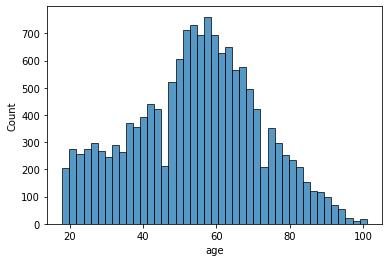

In [44]:
sns.histplot(data = profile_working['age'])

<AxesSubplot:xlabel='income', ylabel='Count'>

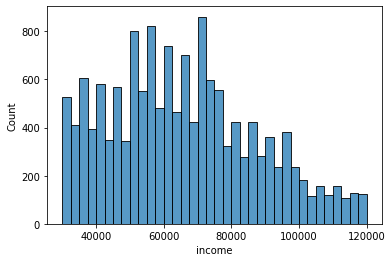

In [45]:
sns.histplot(data = profile_working['income'])

In [46]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

## Transcript

In [47]:
transcript_working.head()

,event,customer_id,time,offer received,offer viewed,transaction,offer completed,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [48]:
transcript_working[['offer received','offer viewed','transaction','offer completed']].sum()

offer received      66501
offer viewed        49860
transaction        123957
offer completed     32444
dtype: int64

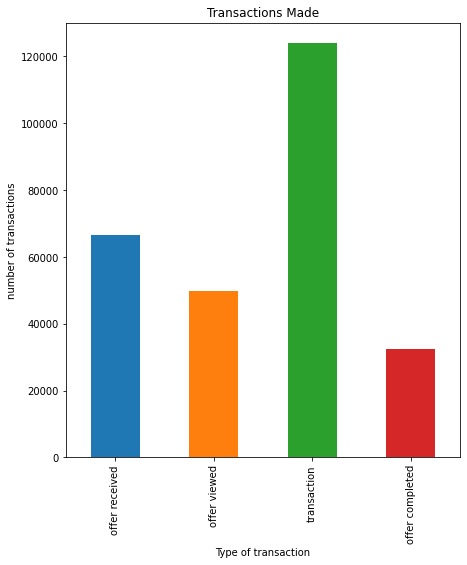

In [49]:
plt.subplot(131)
transaction = transcript_working[['offer received','offer viewed','transaction','offer completed']].sum()
transaction.plot(kind='bar', figsize=(24,8))
plt.ylabel('number of transactions')
plt.xlabel('Type of transaction')
plt.title('Transactions Made');

In [51]:
transcript_profile_cb = pd.merge(transcript_working, profile_working, on='customer_id')
final_dataframe = pd.merge(transcript_profile_cb, portfolio_working, on='offer_id', how='left')

final_dataframe.head()

,event,customer_id,time,offer received,offer viewed,transaction,offer completed,offer_id,amount,age,...,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,...,5.0,7.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,...,5.0,7.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,1,0,NaN,19.89,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,...,5.0,7.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,1,0,NaN,17.78,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
final_dataframe[final_dataframe['offer received'] == 1][['bogo','discount','informational']].sum(axis=0)

bogo             26537.0
discount         26664.0
informational    13300.0
dtype: float64

In [53]:
final_dataframe.shape

(272762, 26)

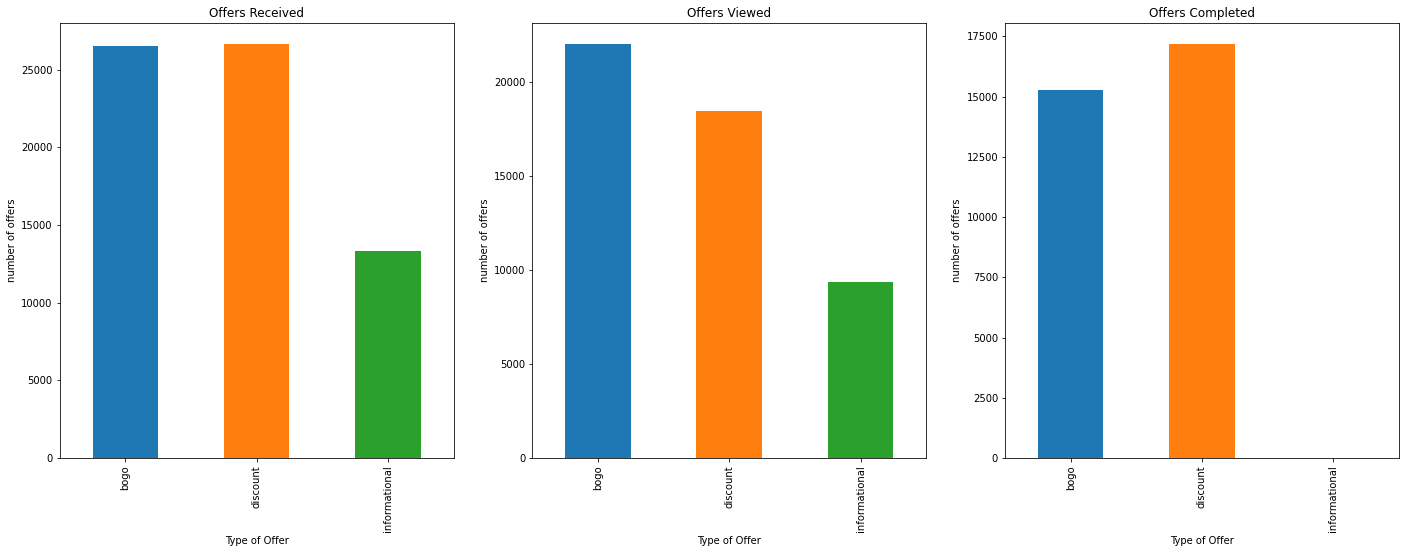

In [54]:
plt.subplot(131)
offer_received = final_dataframe[final_dataframe['offer received'] == 1][['bogo','discount','informational']].sum(axis=0)
offer_received.plot(kind='bar', figsize=(24,8))
plt.ylabel('number of offers')
plt.xlabel('Type of Offer')
plt.title('Offers Received');

plt.subplot(132)
offer_viewed = final_dataframe[final_dataframe['offer viewed'] == 1][['bogo','discount','informational']].sum(axis=0)
offer_viewed.plot(kind='bar' , figsize=(24,8))
plt.ylabel('number of offers')
plt.xlabel('Type of Offer')
plt.title('Offers Viewed');

plt.subplot(133)
offer_completed = final_dataframe[final_dataframe['offer completed'] == 1][['bogo','discount','informational']].sum(axis=0)
offer_completed.plot(kind='bar' , figsize=(24,8))
plt.ylabel('number of offers')
plt.xlabel('Type of Offer')
plt.title('Offers Completed');

## Data Preparation

It becomes important to understand how data is arranged across these 3 datasets. The transcript data has all the transactions saved: Offer received, offer viewed, transaction made, offer completed. Offer received, viewed and completed are all directly linked to offer id and hence the other attributed of the offers like the duration etc., but the transaction is not directly linked to any offer because it is unknown to us. The customer might or might not make a transaction in order to avail an offer. All the transactions need not be to avail an offer and moreover, only the customer knows why a transaction is made and is not explicit.

In [55]:
!pip uninstall -y progressbar
!pip install progressbar2


Skipping progressbar as it is not installed.


In [56]:
import time
import progressbar

In [61]:
#https://pypi.org/project/progressbar2/
def create_data(profile_working, portfolio_working, non_transaction_df, transaction_df):
    '''
    INPUT:
        profile_working - Customer Profiles
        portfolio_working - offer portfolios for all the 10 types of offers
        non_transcation_df - details of offers received, viewed and completed
        transcation_df - details of financial transactions made by customers at starbucks
    OUTPUT:
        final_data - A dataframe that says whether an offer is successful or not and has all the financial and offer transaction
        details merged in a single dataframe.
    FUNCTION:
        The function looks at each offer received by customers in the non_transaction_df and based on the time and duration,
        finds out if it is a successful transaction and sums up the amount spent by a customer on each offer id. 
    '''
        
    final_data = []
    customer_ID = non_transaction_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # All the customer ids in non_transaction_df are being looped through
    for i in progressbar.progressbar(range(len(customer_ID)), widgets=widgets):
        
        # loop through customer id
        idx = customer_ID[i]
        
        # get the profile of the customer
        get_customer = profile_working[profile_working['customer_id']==idx]
        #print("get_customer:\n", get_customer)
        # get the non_transaction data(data of offers) for the id
        non_trasaction_info= non_transaction_df[non_transaction_df['customer_id']==idx]
        #print('non_trasaction_info:', non_trasaction_info)
        # extract transactions associated with the customer from transactions_df
        transaction_info = transaction_df[transaction_df['customer_id']==idx]
        #print('transaction_info', transaction_info)
        # extract received, completed, viewed offer data from customer offers
        offer_received_info = non_trasaction_info[non_trasaction_info['offer received'] == 1]
        offer_completed_info = non_trasaction_info[non_trasaction_info['offer completed'] == 1]
        offer_viewed_info = non_trasaction_info[non_trasaction_info['offer viewed'] == 1]
        #print('offer_completed_info',offer_completed_info)
        rows = []
        # iterating through every received offer
        for offer in range(offer_received_info.shape[0]):
            
            # iterating through offer id
            offer_id = offer_received_info.iloc[offer]['offer_id']
            #print('offer_id-',offer_id)
            # looking at the offer in portfolio
            offer_portfolio = portfolio_working.loc[portfolio_working['offer_id'] == offer_id]
            #print('offer_portfolio-',offer_portfolio)
            # getting the duration for the offer
            duration = offer_portfolio['duration'].values[0]
            #print('duration-',duration)
            # calculating the start and end time of the offer period
            offer_start = offer_received_info.iloc[offer]['time']
            offer_end= offer_start + duration
            
            # completed offers
            completed_offers = np.logical_and(
                offer_completed_info['time'] >= offer_start, offer_completed_info['time'] <= offer_end)
            #print('completed_offers-',completed_offers)
            # offers viewed
            offers_viewed= np.logical_and(
                offer_viewed_info['time'] >= offer_start, offer_viewed_info['time'] <=offer_end)
            #print('offers_viewed-',offers_viewed)
            # Marking successful offers as 1
            successful_offer = completed_offers.sum() > 0 and offers_viewed.sum() > 0
            #print('successful_offer-',successful_offer)
            # getting transactions that occured before offer expiry
            successful_transactions= np.logical_and(
                transaction_info ['time'] >= offer_start, transaction_info['time'] <= offer_end)
            #print('successful_transactions-',successful_transactions)
            transaction_data = transaction_info[successful_transactions]
            #print('transaction_data-',transaction_data)
            # Total amount spent on transactions
            overall_transaction_amount = transaction_data['amount'].sum()
            #print('overall_transaction_amount-',overall_transaction_amount)
            row = {
                'offer_id': offer_id,
                'customer_id': idx,
                'time': offer_start,
                'total_amount': overall_transaction_amount,
                'successful_offer': int(successful_offer),
            }
                
            row.update(offer_portfolio.iloc[0,0:].to_dict())

            row.update(get_customer.iloc[0,:].to_dict())

            rows.append(row)
        
        final_data.extend(rows)
    
    final_data= pd.DataFrame(final_data)
    return final_data

In [62]:
final_data = create_data(profile_working, portfolio_working, non_transaction_df, transaction_df)

 [Elapsed Time: 0:13:46] |##################################| (Time:  0:13:46) 


In [63]:
final_data.successful_offer.value_counts()

0    35136
1    31365
Name: successful_offer, dtype: int64

In [64]:
final_data.to_csv('final_data.csv', encoding='utf-8', index=False)

In [84]:
import pandas as pd
final_data = pd.read_csv('final_data.csv')

In [85]:
final_data.shape

(66501, 22)

In [86]:
final_data['successful_offer'].value_counts()

0    35136
1    31365
Name: successful_offer, dtype: int64

In [87]:
final_data.columns

Index(['F', 'M', 'O', 'age', 'bogo', 'customer_id', 'difficulty', 'discount',
       'duration', 'email', 'income', 'informational', 'mobile', 'offer_id',
       'reward', 'social', 'start_month', 'start_year', 'successful_offer',
       'time', 'total_amount', 'web'],
      dtype='object')

## 1. Number of offers received in each offer type and which of them has higher success rate

In [88]:
#offer received in each offer type
final_data[['bogo','discount','informational']].sum()

bogo             26537
discount         26664
informational    13300
dtype: int64

In [89]:
#how many of them were successful
print(final_data[final_data['bogo']==1]['successful_offer'].sum())
print(final_data[final_data['discount']==1]['successful_offer'].sum())
print(final_data[final_data['informational']==1]['successful_offer'].sum())

14342
16092
931


In [90]:
#proportion of success to received
proportion_success_bogo = final_data[final_data['bogo']==1]['successful_offer'].sum()/final_data['bogo'].sum()
proportion_success_discount = final_data[final_data['discount']==1]['successful_offer'].sum()/final_data['discount'].sum()
proportion_success_informational = final_data[final_data['informational']==1]['successful_offer'].sum()/final_data['informational'].sum()

In [91]:
#combing the data
proportion = {'proportion_success_bogo':proportion_success_bogo, 'proportion_success_discount':proportion_success_discount, 'proportion_success_informational':proportion_success_informational}

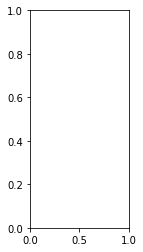

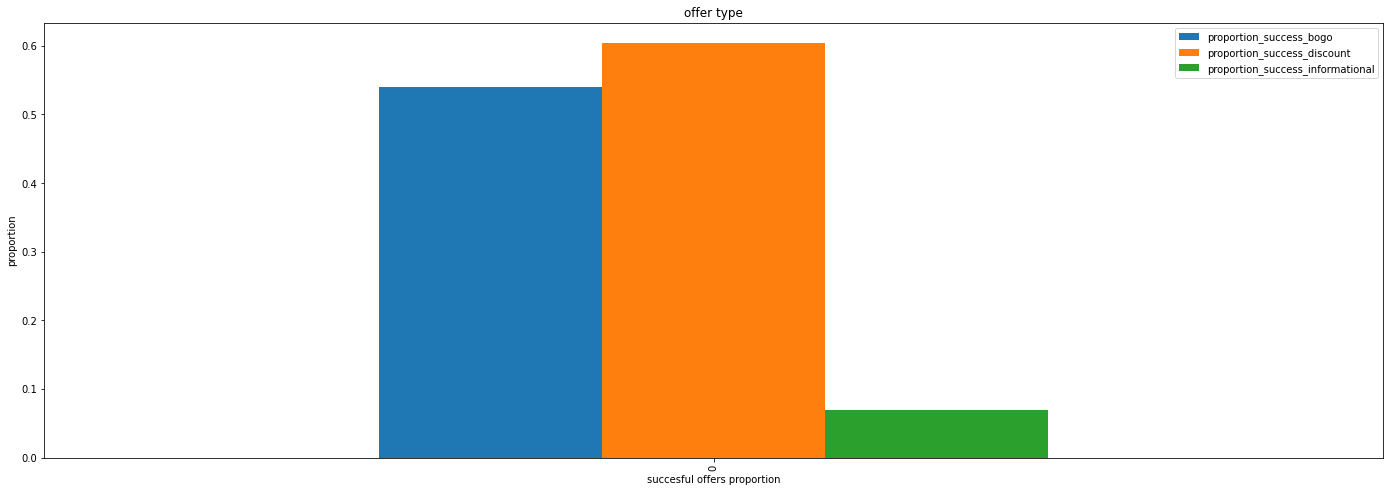

In [92]:
#plotting the proportion across offer types
proportion = pd.DataFrame(data = proportion, index=[0])
plt.subplot(131)
proportion.plot(kind='bar', figsize=(24,8))
plt.ylabel('proportion')
plt.xlabel('succesful offers proportion')
plt.title('offer type');

## 2. Number of offer received in each offer id and number of them successful:

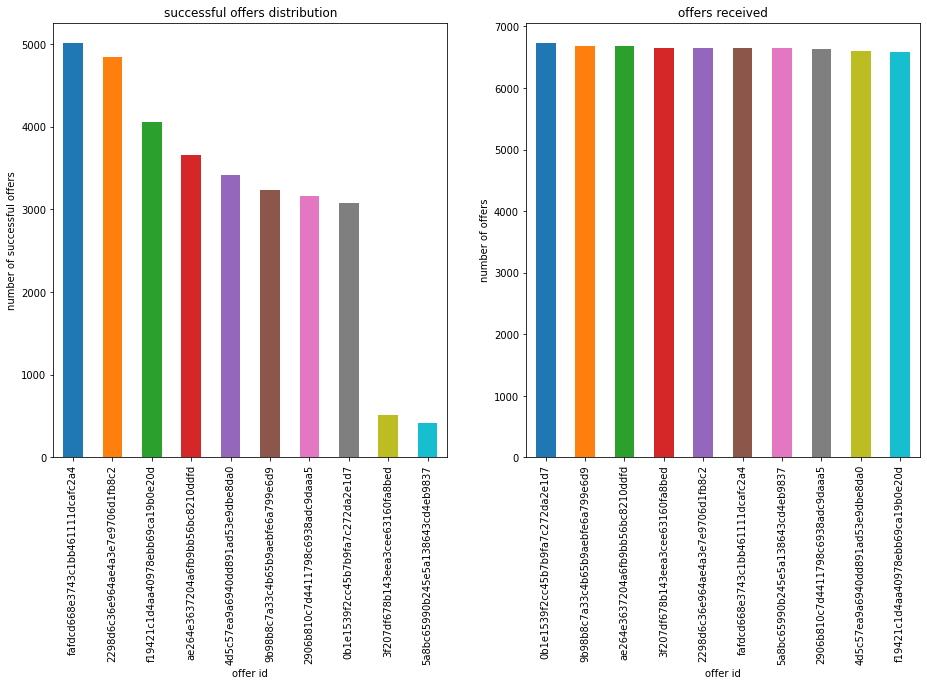

In [93]:
#plotting the number of successful offers across offer ids
plt.subplot(131)
offer_id = final_data[final_data['successful_offer']==1]['offer_id'].value_counts()
offer_id.plot(kind='bar', figsize=(24,8))
plt.ylabel('number of successful offers')
plt.xlabel('offer id')
plt.title('successful offers distribution');
#plotting the number of offers received in each offer id
plt.subplot(132)
offer_id = final_data['offer_id'].value_counts()
offer_id.plot(kind='bar', figsize=(24,8))
plt.ylabel('number of offers')
plt.xlabel('offer id')
plt.title('offers received');

In [94]:
final_data[final_data['successful_offer']==1]['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5008
2298d6c36e964ae4a3e7e9706d1fb8c2    4841
f19421c1d4aa40978ebb69ca19b0e20d    4052
ae264e3637204a6fb9bb56bc8210ddfd    3652
4d5c57ea9a6940dd891ad53e9dbe8da0    3410
9b98b8c7a33c4b65b9aebfe6a799e6d9    3228
2906b810c7d4411798c6938adc9daaa5    3165
0b1e1539f2cc45b7b9fa7c272da2e1d7    3078
3f207df678b143eea3cee63160fa8bed     514
5a8bc65990b245e5a138643cd4eb9837     417
Name: offer_id, dtype: int64

Though all the offers are equally received, some are more successful than others

In [95]:
offer_id_values = list(final_data[final_data['successful_offer']==1]['offer_id'].value_counts().index)

## 3. Model Building

<b>Train Test Split

In [96]:
final_data.columns

Index(['F', 'M', 'O', 'age', 'bogo', 'customer_id', 'difficulty', 'discount',
       'duration', 'email', 'income', 'informational', 'mobile', 'offer_id',
       'reward', 'social', 'start_month', 'start_year', 'successful_offer',
       'time', 'total_amount', 'web'],
      dtype='object')

In [97]:
# dropping customer id and time columns as they are irrelavant
final_data.drop(columns = ['time', 'customer_id'], inplace = True)

In [98]:
final_data.columns

Index(['F', 'M', 'O', 'age', 'bogo', 'difficulty', 'discount', 'duration',
       'email', 'income', 'informational', 'mobile', 'offer_id', 'reward',
       'social', 'start_month', 'start_year', 'successful_offer',
       'total_amount', 'web'],
      dtype='object')

In [99]:
#Encoding offer ids across columns
for i in offer_id_values:
    final_data[i] = final_data['offer_id'].apply(lambda x:1 if x==1 else 0)
final_data.drop(columns='offer_id', inplace = True)
final_data.head()

,F,M,O,age,bogo,difficulty,discount,duration,email,income,...,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,f19421c1d4aa40978ebb69ca19b0e20d,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2906b810c7d4411798c6938adc9daaa5,0b1e1539f2cc45b7b9fa7c272da2e1d7,3f207df678b143eea3cee63160fa8bed,5a8bc65990b245e5a138643cd4eb9837
0,1,0,0,75.0,1,5,0,7,1,100000.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,75.0,0,0,0,3,1,100000.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,75.0,1,10,0,7,1,100000.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,75.0,1,5,0,5,1,100000.0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,68.0,0,10,1,7,1,70000.0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
X = final_data.drop(columns = ['successful_offer'])

In [101]:
y = final_data['successful_offer']

In [105]:
#Building a Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score 
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
f1score = f1_score(y_test, yhat)
print('Accuracy of Logistic Regression: %.3f' % acc)
print('F1 Score of Logistic Regression : %.3f' % f1score)

Accuracy of Logistic Regression: 0.875
F1 Score of Logistic Regression : 0.863


In [106]:
#Building a random forest model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
f1score = f1_score(y_test, yhat)
print('Accuracy of RandomForest: %.3f' % acc)
print('F1 Score of RandomForest: %.3f' % f1score)

Accuracy of RandomForest: 0.903
F1 Score of RandomForest: 0.896


Conclusion:
The study aimed at predicting the success of an offer to a customer and at finding the offer type and offer id with highest success rate . The major challenge with the project was in preparing the data. As purchase data is automatically stored with no connection with offers, mapping the purchase data with offers and customer data seemed not only to be to be the main challenge but also the principle component of the study. 
The prediction model built with random forest has a very good accuracy and f score of 0.905 and 0.895. Discount seems in general to give more success rate than other offer types. A discount offer with a reward of 2, difficulty 10 and duration 10, advertised through all 4 channels had the best success rate than other offer ids. 
Having more details of the demography and on offers would allow to study the reasons behind purchasing decisions in a deeper way.